In [1]:
import numpy as np
import pandas as pd
import math

import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly.express as px

from feature_engine.imputation.mean_median import MeanMedianImputer
from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [2]:
# Combine datasets

data1 = pd.read_csv('train.csv')
data2 = pd.read_csv('test.csv')
data = pd.concat([data1, data2])

In [3]:
# Reset index

data = data.loc[~data.index.duplicated(), :]

In [4]:
# Briefly inspect data

data.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   
2                                  2  ...                       5   
3                                  5  ...                       2   
4                                  3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

In [5]:
# Drop unnecessary features

data = data.drop(['id', 'Unnamed: 0'], axis=1)

In [6]:
# Explore data distribution

data.describe()

Age  Flight Distance  Inflight wifi service  \
count  103904.000000    103904.000000          103904.000000   
mean       39.379706      1189.448375               2.729683   
std        15.114964       997.147281               1.327829   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       843.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      103904.000000           103904.000000   
mean                            3.060296                2.756901   
std                             1.525075                1.398929   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103904.000000   103904.000000    103904.000000  103904.000000   
mean        2.976883        3.202129         3.250375       3.439396   
std         1.277621        1.329533         1.349509       1.319088   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103904.000000     103904.000000     103904.000000   
mean                 3.358158          3.382363          3.351055   
std                  1.332991          1.288354          1.315605   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103904.000000    103904.000000     103904.000000  103904.000000   
mean           3.631833         3.304290          3.640428       3.286351   
std            1.180903         1.265396          1.175663       1.312273   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103904.000000             103594.000000  
mean                    14.815618                 15.178678  
std                     38.230901                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

In [7]:
# Outliers suggested for features: flight distance, arrival delay and departure delay.

In [8]:
# Inspect feature data type and non-null counts

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [9]:
# Calculate % of missing data

data_na = round(data.isnull().mean()*100, 2)
data_na[data_na > 0]

Arrival Delay in Minutes    0.3
dtype: float64

In [10]:
# Since missing data amount low, to only mean impute

mean_imputer = MeanMedianImputer(imputation_method='mean', variables='Arrival Delay in Minutes')
data_imputed = mean_imputer.fit_transform(data)

<AxesSubplot:xlabel='Gender', ylabel='count'>

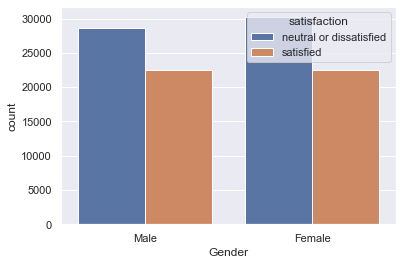

In [11]:
sns.countplot(data=data_imputed, x='Gender', hue='satisfaction')

In [12]:
# Similiar gender counts and no notable relationship with satisfaction levels 

<AxesSubplot:xlabel='Class', ylabel='count'>

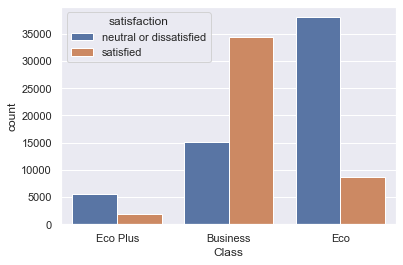

In [13]:
sns.countplot(data=data_imputed, x='Class', hue='satisfaction')

In [14]:
# Most passengers from Business and Eco classes
# Much more business class passengers satisfied than neutral/dissatisfied - reverse true for eco class 

<AxesSubplot:xlabel='Age', ylabel='Count'>

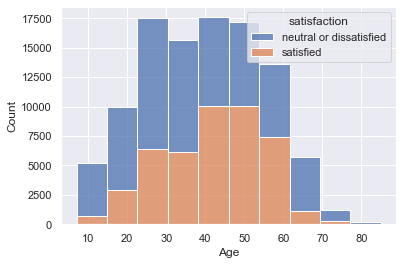

In [15]:
sns.histplot(data=data, x='Age', hue='satisfaction', multiple='stack', bins=10)

In [16]:
# Majority of passengers fall within 20-60 bracket
# 40-60 bracket associated with satisfication majority - reverse true for other ages

<AxesSubplot:xlabel='Class', ylabel='Age'>

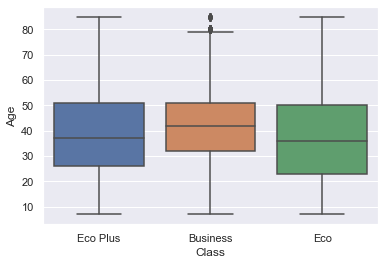

In [17]:
# Explore whether satisfaction difference in age brackets relates to class of travel

sns.boxplot(data=data_imputed, x='Class', y='Age')

In [18]:
# IQR of business class relates to slightly older age bracket
# However, no significant relationship between age and classses (eco and business)

<AxesSubplot:xlabel='Flight Distance', ylabel='Count'>

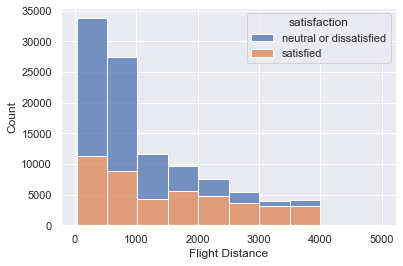

In [19]:
sns.histplot(data=data, x='Flight Distance', hue='satisfaction', multiple='stack', bins=10)

In [20]:
# Satisfaction ratio clearly improving with increased flight distance

<AxesSubplot:xlabel='Class', ylabel='Flight Distance'>

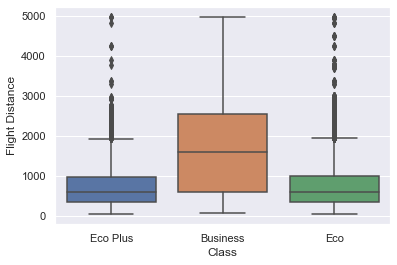

In [21]:
sns.boxplot(data=data_imputed, x='Class', y='Flight Distance')

In [22]:
# Business class assoicated with much greater flight distance than eco 
# 2 clear clusters emerging of between satsified and neutral/dissatisfied passengers based on travel class and flight distance

<AxesSubplot:xlabel='Cleanliness', ylabel='count'>

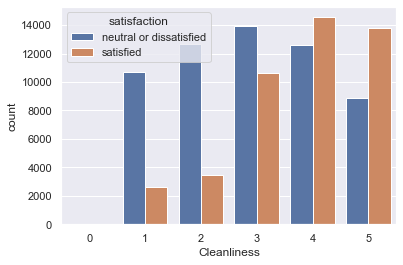

In [23]:
sns.countplot(data=data_imputed, x='Cleanliness', hue='satisfaction')

<AxesSubplot:xlabel='Leg room service', ylabel='count'>

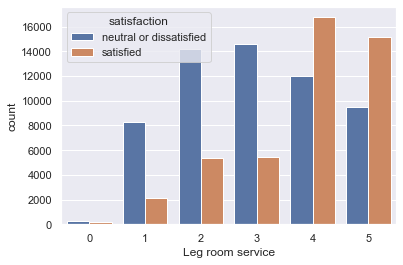

In [24]:
sns.countplot(data=data_imputed, x='Leg room service', hue='satisfaction')

<AxesSubplot:xlabel='Inflight entertainment', ylabel='count'>

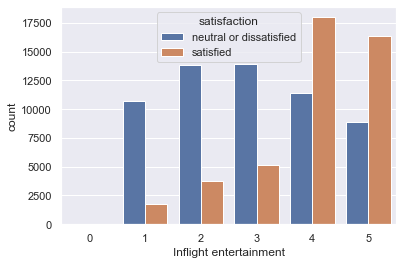

In [25]:
sns.countplot(data=data_imputed, x='Inflight entertainment', hue='satisfaction')

In [26]:
# Clear distinctions in overall satisfaction and individual services noted

In [27]:
# One-hot encode categorical variables

data_encoded = data_imputed.copy()

data_encoded = pd.get_dummies(data_encoded, drop_first=True)

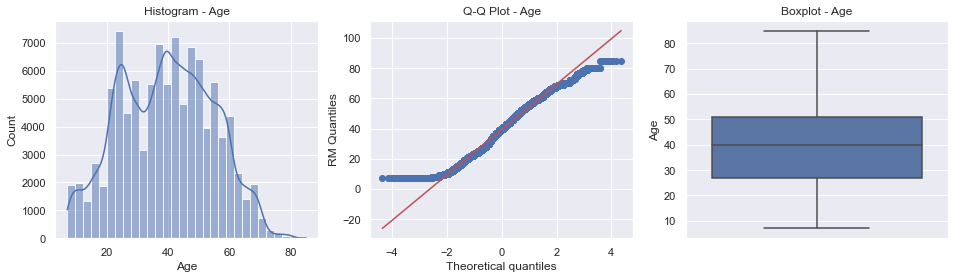

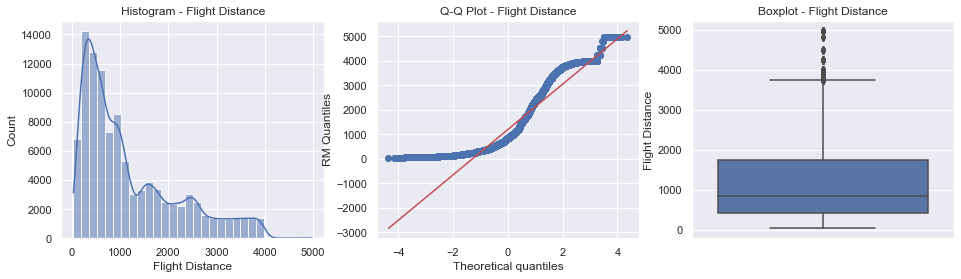

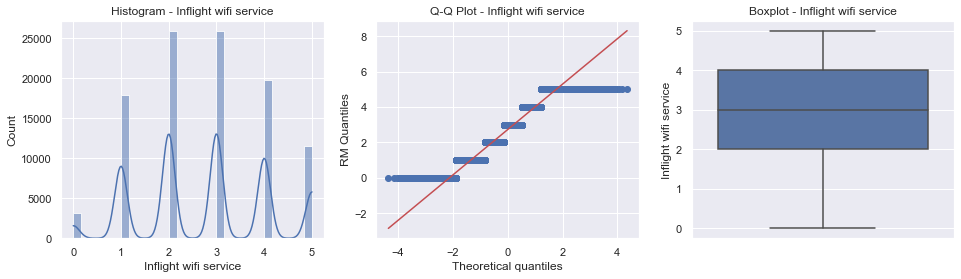

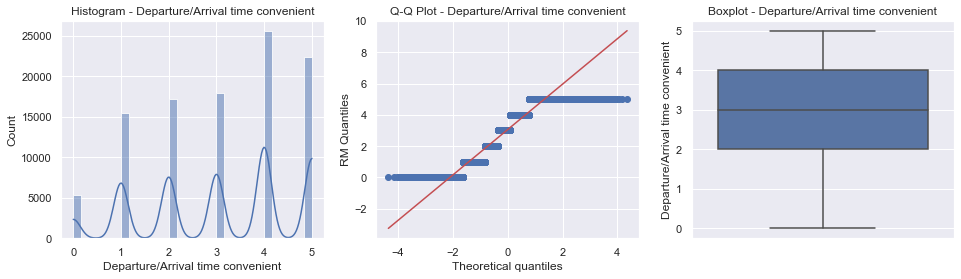

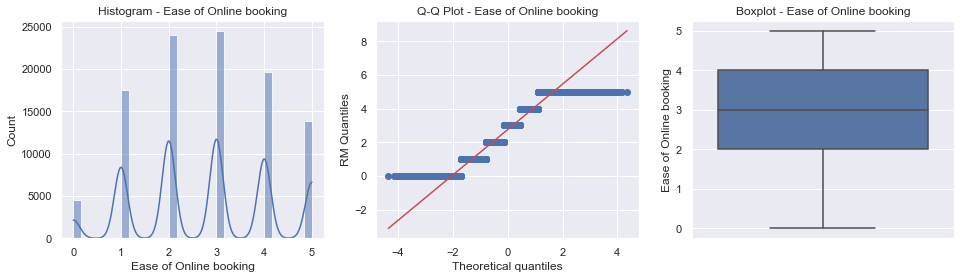

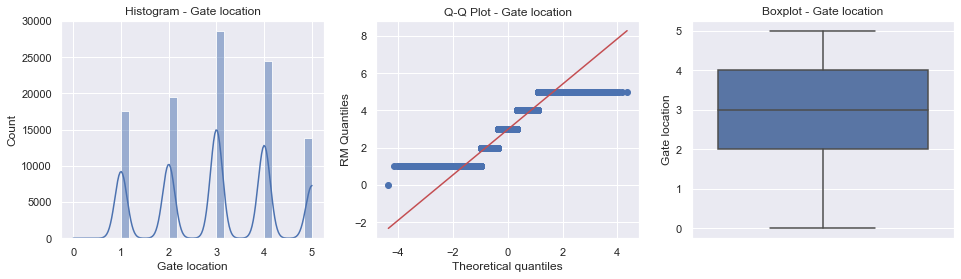

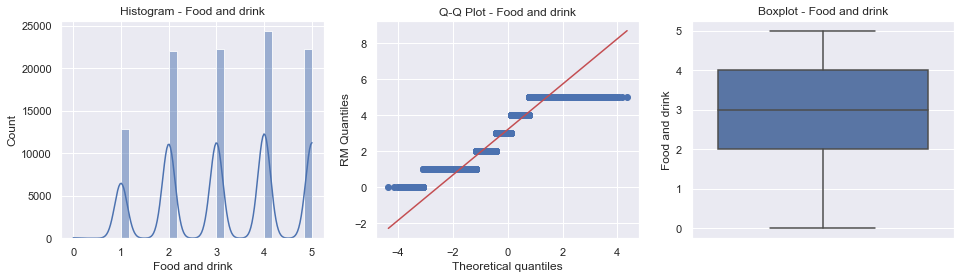

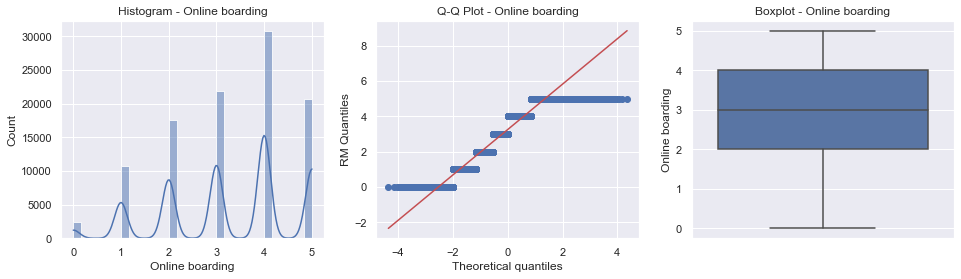

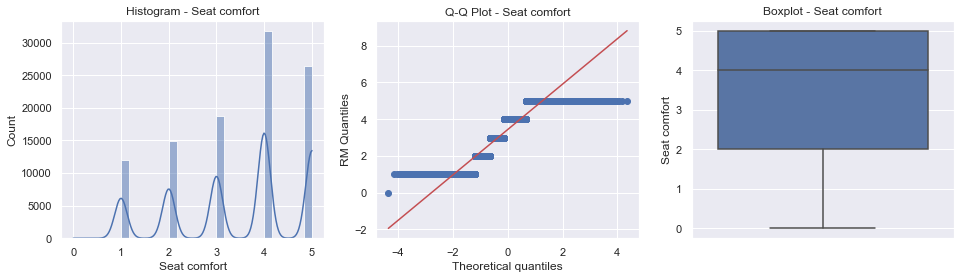

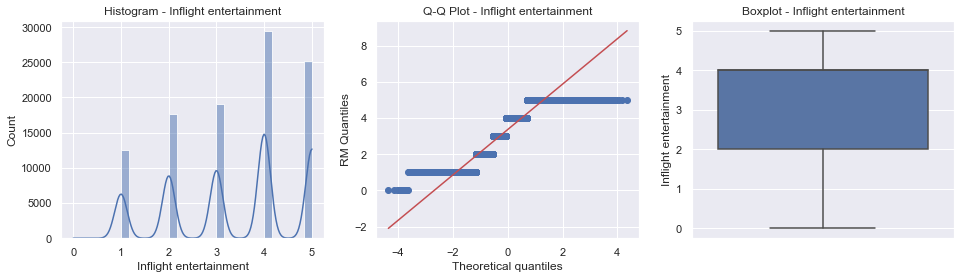

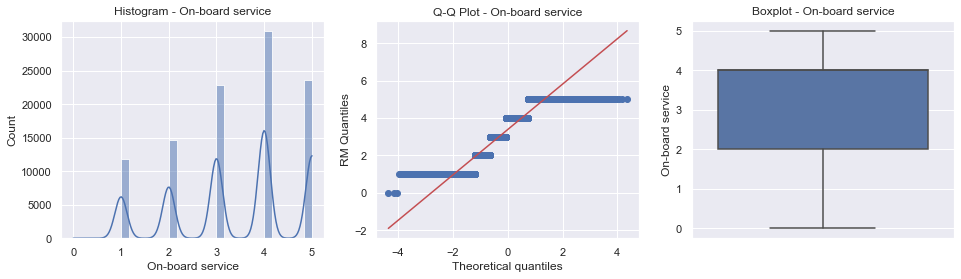

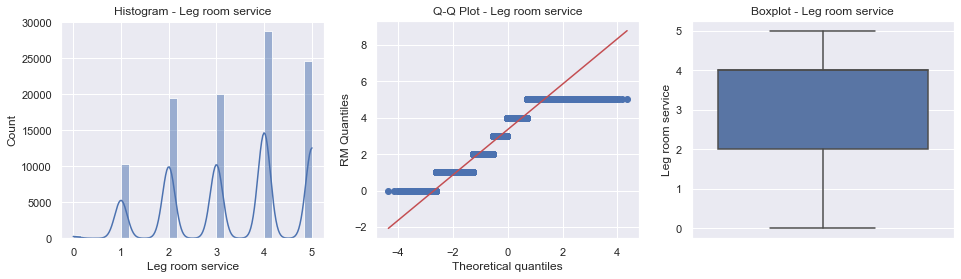

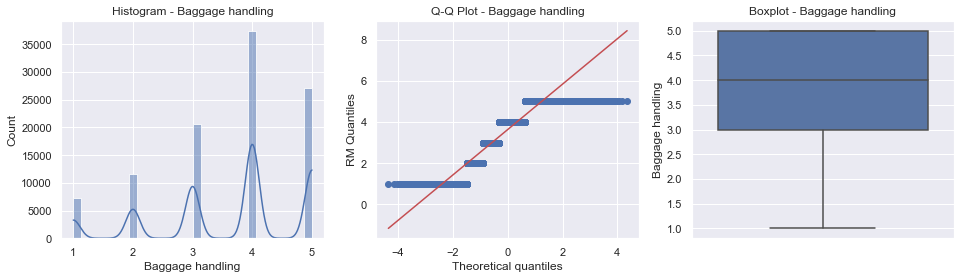

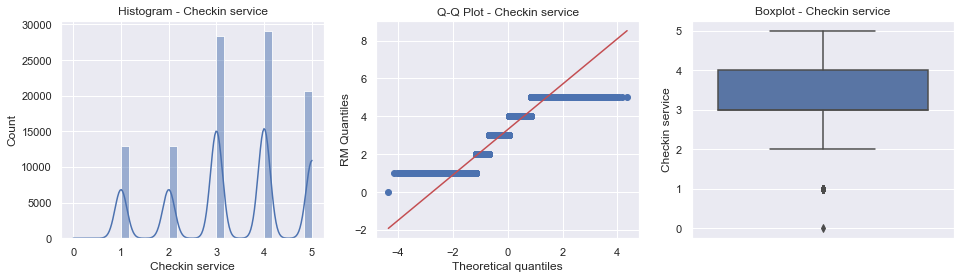

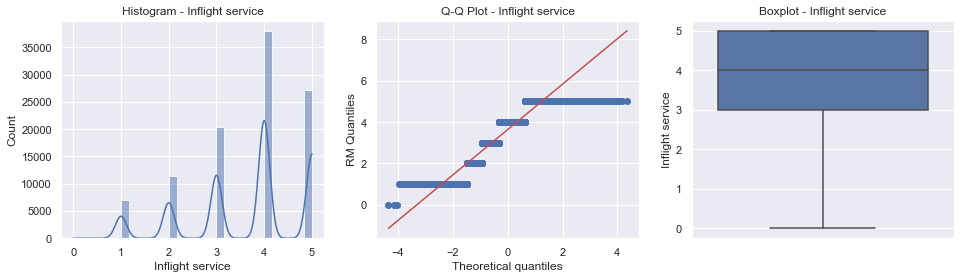

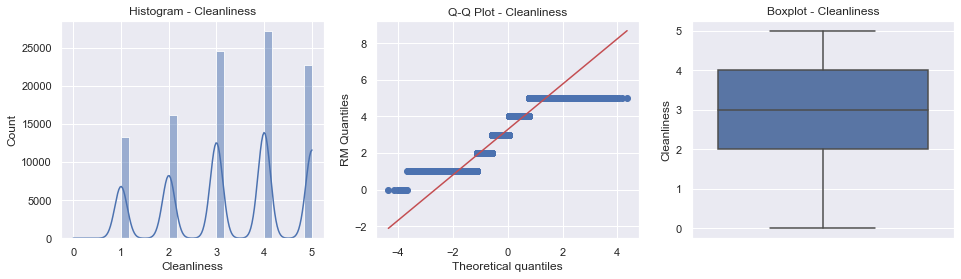

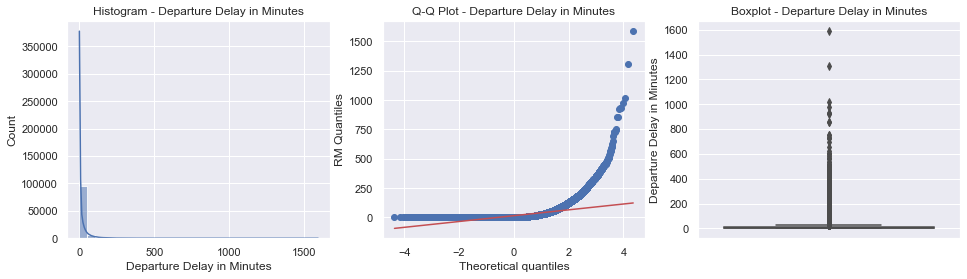

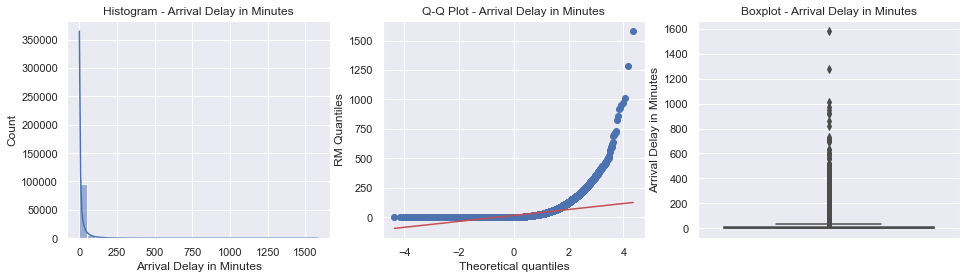

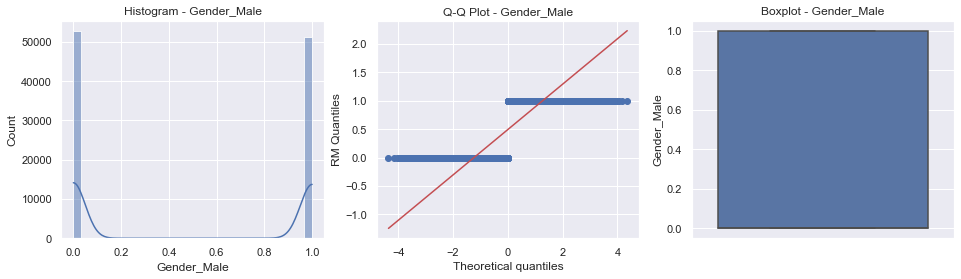

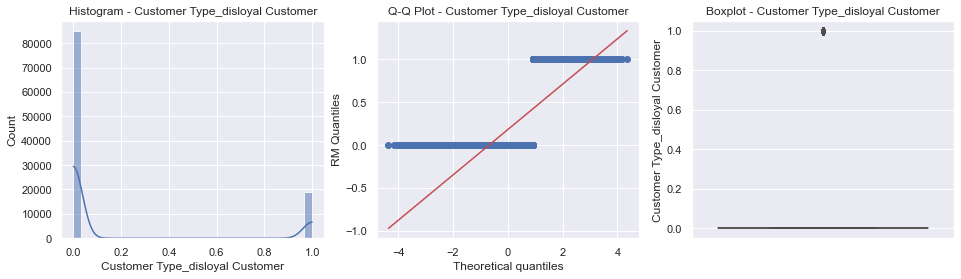

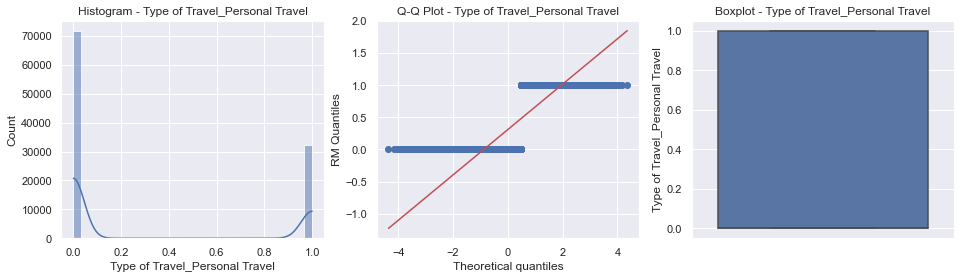

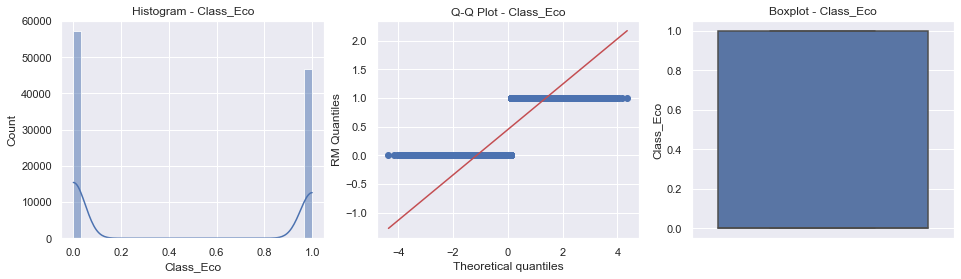

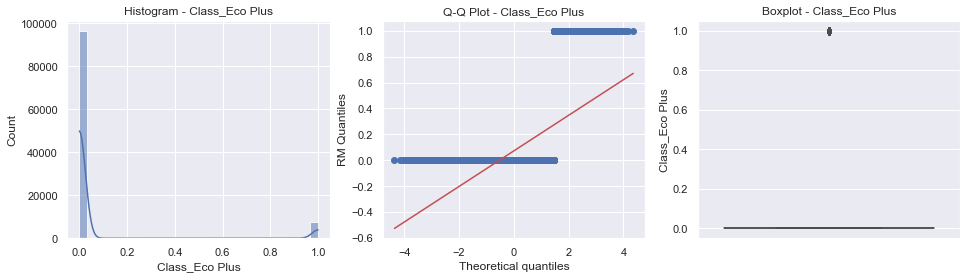

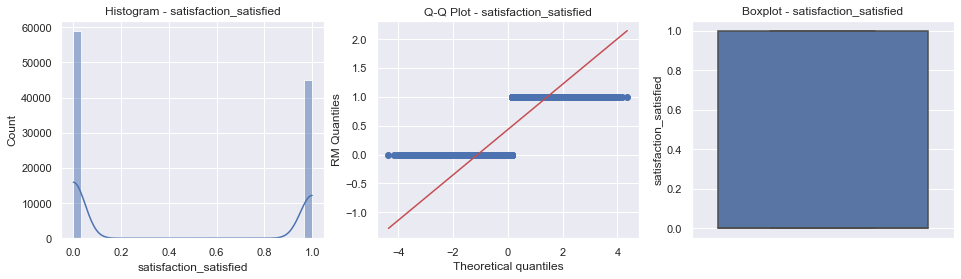

In [28]:
# Run diagnostic plots to explore distributions and check for outliers.

def diagnostic_plots(df, variable):
  plt.figure(figsize=(16,4))

  plt.subplot(1,3,1)
  sns.histplot(df[variable], bins=30, kde=True)
  plt.title(f'Histogram - {variable}')

  plt.subplot(1,3,2)
  stats.probplot(df[variable], dist='norm', plot=plt)
  plt.ylabel('RM Quantiles')
  plt.title(f'Q-Q Plot - {variable}')

  plt.subplot(1,3,3)
  sns.boxplot(y=df[variable])
  plt.title(f'Boxplot - {variable}')

  plt.show()

for i in range(data_encoded.shape[1]):
  diagnostic_plots(data_encoded, data_encoded.columns[i]) 

In [29]:
# Apply trimmer to handle outliers

windsoriser = Winsorizer(capping_method = 'iqr',
                        tail='both',
                        fold=1.5,
                        variables=['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'])
data_trimmed = windsoriser.fit_transform(data_encoded)

<AxesSubplot:xlabel='Arrival Delay in Minutes'>

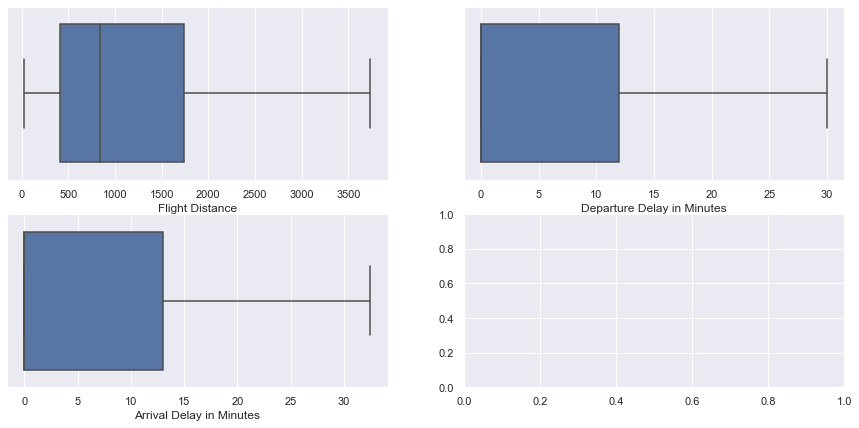

In [30]:
# Check trimming sufficiently handled outliers

fig, ax = plt.subplots(2, 2, figsize=(15,7), sharey=False)
axes = ax.flatten()

sns.boxplot(data=data_trimmed, x='Flight Distance', ax=axes[0])
sns.boxplot(data=data_trimmed, x='Departure Delay in Minutes', ax=axes[1])
sns.boxplot(data=data_trimmed, x='Arrival Delay in Minutes', ax=axes[2])

In [31]:
# Check for multicollinearity (MC)

features = list(data_trimmed.corr().columns)

fig = px.imshow(data_trimmed.corr(), x=features, y=features, height=700, width=700)
fig.show()

In [32]:
# At >0.7 correlation coeffieient (CC) threshold, MC identified between the following features:
# 'Inflight wifi service' and 'Ease of Online booking' (CC: 0.7158561)
# 'Departure Delay in Minutes' and 'Arrival Delay in Minutes' (CC: 0.8403821)

# A few other features identified as borderline.
# To apply PCA to reduce feature space and eliminate MC.

In [33]:
# Standardise scales

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_trimmed)
scaled_data = pd.DataFrame(scaled_data, columns=data_trimmed.columns)

Text(0, 0.5, 'cumulative explained variance')

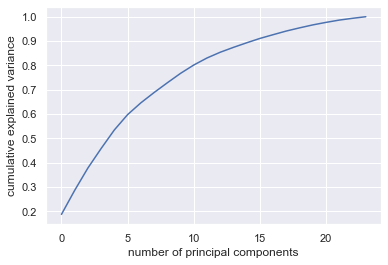

In [34]:
# Determine number of PCs

pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of principal components')
plt.ylabel('cumulative explained variance')

In [35]:
# To proceed with 15 PCs based on >90% explained variance threshold

In [36]:
pca = PCA(n_components=15)
pca_data = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame(pca_data, columns=['col_1', 'col_2', 'col_3', 'col_4',
                                           'col_5', 'col_6', 'col_7', 'col_8',
                                           'col_9', 'col_10', 'col_11', 'col_12',
                                           'col_13', 'col_14', 'col_15'])

In [37]:
# Check MC eliminated

features = list(pca_data.corr().columns)

fig = px.imshow(pca_data.corr(), x=features, y=features, height=300, width=300)
fig.show()

Text(0, 0.5, 'Inertia')

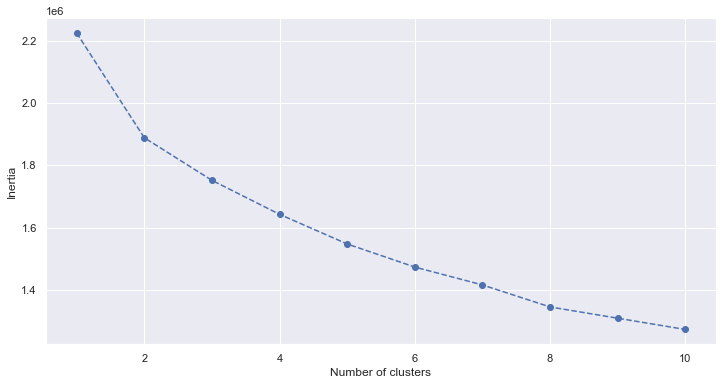

In [38]:
### K-means ###

# Use elbow method to guide cluster number selection

results = []

for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(pca_data) 
    results.append(kmeans_pca.inertia_)
    
frame = pd.DataFrame({'Cluster':range(1,11), 'Results':results})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['Results'], marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

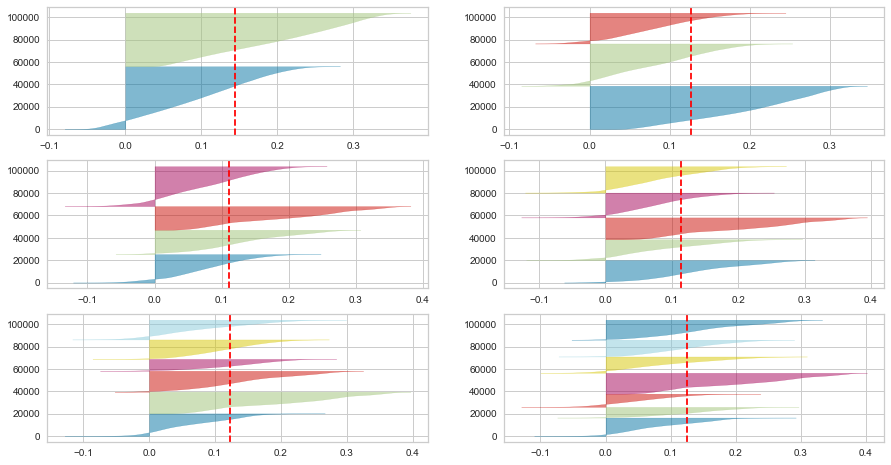

In [39]:
# Use silhouette plots to further explore optimal cluster number

from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in range(2,8):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pca_data)

In [40]:
# To proceed with 2, rather than 3, given more uniform cluster size and favourable silhouette score.   

In [41]:
km = KMeans(n_clusters=2, init='k-means++', random_state=42)
km.fit(pca_data)

KMeans(n_clusters=2, random_state=42)

In [42]:
silhouette_score(pca_data, km.labels_, metric='euclidean')

0.14447065982473298

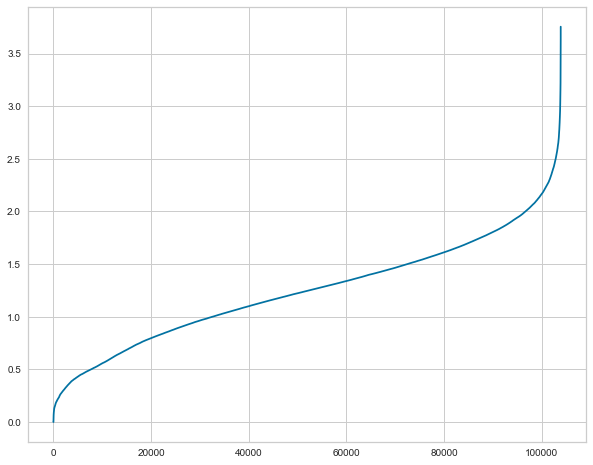

In [43]:
### DBScan ###

nn = NearestNeighbors(n_neighbors=20).fit(pca_data)
distances, indices = nn.kneighbors(pca_data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [ ]:
eps = np.arange(2.6,3.2,0.1)

output = []

for ep in eps:
  labels = DBSCAN(min_samples=20, eps = ep).fit(pca_data).labels_
  score = silhouette_score(pca_data, labels)
  output.append((ep, score))

eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"eps: {eps}")

In [ ]:
# To proceed with eps=3.1 and min_samples=20 (2 * feature number) 

In [ ]:
db = DBSCAN(eps=3.1, min_samples=20).fit(pca_data) 

In [ ]:
silhouette_score(pca_data, db.labels_)

In [ ]:
### Gaussian Mixture Model ###

gm = GaussianMixture(n_components=2)
gm.fit(pca_data)

gm_labels = gm.predict(pca_data)

In [ ]:
silhouette_score(pca_data, gm_labels)

In [ ]:
### Mean Shift ###

bandwidth = estimate_bandwidth(pca_data, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth)
ms.fit(pca_data)

In [ ]:
silhouette_score(pca_data, ms.labels_)

In [ ]:
## To proceed with K-means model based on scoring

In [ ]:
# Assign cluster number to rows of dataset

data_clusters = data_trimmed.copy()

data_clusters['Clusters'] = db.labels_
clustered_data = data_clusters.groupby('Clusters').mean()
clustered_data

In [ ]:
# Explore relationship between cluster number and features

features = data_clusters.columns

for feature in features:
    plt.figure()
    sns.boxplot(y = data_clusters[feature], x = data_clusters["Clusters"])
    plt.show()

In [120]:
## Segment Analysis

# Segment 1:
# - Prodominates the 40-60 age bracket and business travel.
# - Higher overall satisfaction.
# - Increasing trend in satisfaction score with individual services - peaking at scores 4 or 5.
# - Exception, convenience of departure/arrival times - segment 0 scores better.

# Segment 2:
# - Prodominates the <40 age bracket and 'eco' class.
# - Lower overall satisfaction.
# - Bell-shaped trend in satisfaction score with individual services - peaking at 3.
# - Exception, satisfaction with convenience of departure/arrival times - segment 0 scores better.